# Import libraries

In [1]:
from system import DecisionSystem, Image
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.image as mpimg
import seaborn as sns
import cv2
import pandas as pd
import glob

In [2]:
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, LassoLars, LassoLarsCV, SGDRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.metrics import r2_score, explained_variance_score, max_error, mean_absolute_error,mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import joblib
import warnings
warnings.filterwarnings('ignore')
import datetime
import pandas as pd

In [3]:
def mean_relative_error(y_real, y_predicted):
    y_real = np.reshape(y_real, (-1,1))
    y_predicted = np.reshape(y_predicted, (-1,1))
    N = y_real.shape[0]    
    return (np.sum(abs(y_real-y_predicted)/y_real)/N)[0]

In [4]:
PROCESS_IMAGES = False
PROCESS_DATA= False
AUGMENT_IMAGES = False

seed = 2

features= ['area_cc', 'width_bbox', 'height_bbox', 'mayor_axis', 'minor_axis', 'eccentricity', 'perimeter', 'percent_area', 'symmetry_v']
decision_system = DecisionSystem()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


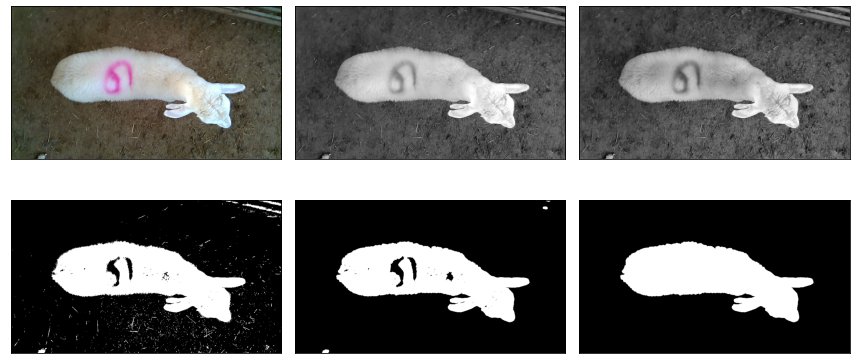

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 100


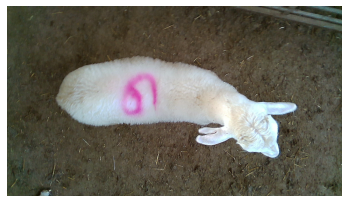

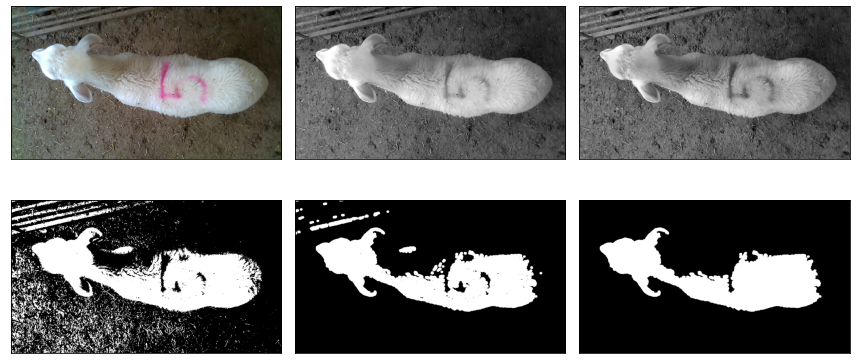

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 100


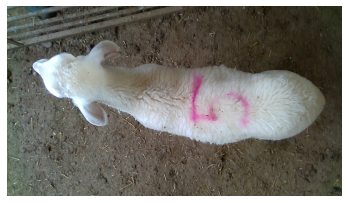

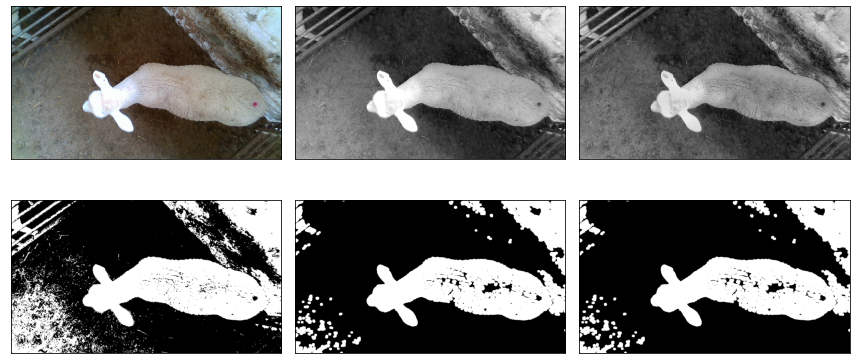

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 100


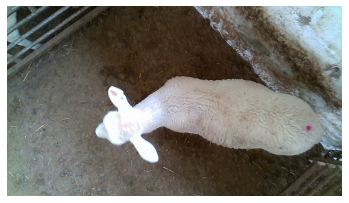

In [5]:
process_images = ['9ae21f9f018d449c87e67cbf7fe488f9','ebd61e0c573f404abb9c00dfbe12a1a9','3c4dcc3c6d83425dab0d0acd75227f99']

for f in process_images:
    img = Image(decision_system, f, '000', 1, 25)
    img.calculate_mask()
    
    sharp = ((img.sharp_img/2)*255).astype(np.uint8)
    lab = ((img.lab_img/100)*255).astype(np.uint8)
    
    fig, ax = plt.subplots(2,3, figsize=(12,6), sharey='row')

    ax[0][0].imshow(img.sharp_img)
    ax[0][1].imshow(lab, cmap='gray')
    ax[0][2].imshow(img.clahe, cmap='gray')
    ax[1][0].imshow(img.clahe_otsu, cmap='gray')
    ax[1][1].imshow(img.original_mask, cmap='gray')
    ax[1][2].imshow(img.mask, cmap='gray')

    for y in ax:
        for axs in y:
            axs.set_xticks([])
            axs.set_yticks([])

    plt.tight_layout()
    plt.show()
    
    cv2.imwrite('../data/process/'+f+'_0_original.png', img.color_image)
    plt.imshow(img.sharp_img),plt.axis('off')
    plt.savefig('../data/process/'+f+'_1_sharp.png', dpi=200, bbox_inches='tight',pad_inches = 0)
    #cv2.imwrite('../data/process/'+f+'_1_sharp.png', sharp)
    cv2.imwrite('../data/process/'+f+'_2_lab.png', lab)
    cv2.imwrite('../data/process/'+f+'_3_clahe.png', img.clahe)
    cv2.imwrite('../data/process/'+f+'_4_otsu.png', img.clahe_otsu)
    cv2.imwrite('../data/process/'+f+'_5_morpho.png', img.original_mask)
    cv2.imwrite('../data/process/'+f+'_6_mask.png', img.mask)
    
    print(img.lab_img.min(), img.lab_img.max())

# Grid Search parameters
Sex has been coded as 1: 'Female', 0: 'Male'

In [6]:
disks = range(3,13, 3)
comps = range(30000, 100000, 20000)

In [7]:
if PROCESS_IMAGES:
    files = [f[:-10] for f in os.listdir('../data/more/mask')]
    for disk in disks:
        for comp in comps:
            folder = '../data/experiments/disk_'+str(disk)+'_comp_'+str(comp)

            if not os.path.exists(folder):
                os.mkdir(folder)

            for f in files:
                img = Image(decision_system, f, 1, 1, 20, comp)
                img.calculate_mask(diskSize=disk)
                cv2.imwrite(os.path.join(folder,img.filename+'.png'), cv2.cvtColor(img.mask, cv2.COLOR_GRAY2RGB))
    grid_search = pd.DataFrame(columns = ['disk', 'component', 'iou'])
    for disk in disks:
        for comp in comps:
            folder = '../data/experiments/disk_'+str(disk)+'_comp_'+str(comp)
            ious= []
            for f in files:
                mask_exp = cv2.imread(folder+'/'+f+'.png')
                mask_real = cv2.imread('../data/more/mask/'+f+'_color.png')
                intersection = ((mask_exp * mask_real)>0).sum()
                union = ((mask_exp + mask_real)>0).sum()
                iou = intersection / union
                ious.append(iou)
            iou_exp = np.array(ious).mean()
            df = pd.DataFrame([{
                'disk': disk,
                'component': comp,
                'iou': iou_exp
            }])
            grid_search = pd.concat([grid_search, df])
    grid_search['iou'] = grid_search['iou'].astype(float)
    grid_search['disk'] = grid_search['disk'].astype(float)
    grid_search['component'] = grid_search['component'].astype(float)

    
    grid_search.to_csv('../data/grid_search.csv')
else:
    grid_search = pd.read_csv('../data/grid_search.csv')

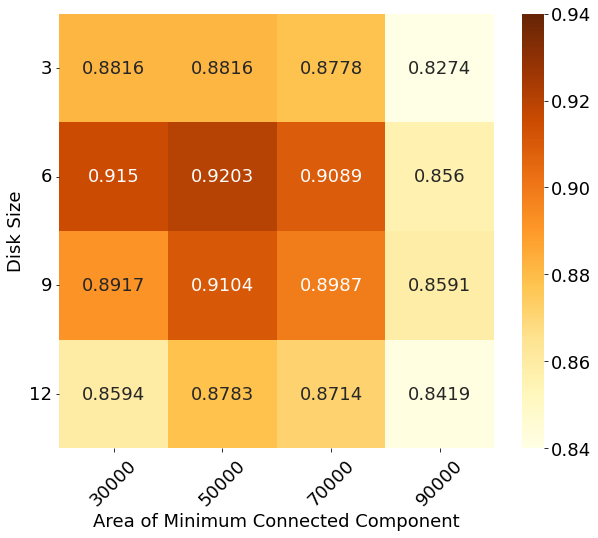

In [8]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10, 8))

grid = grid_search.pivot(index="disk", columns="component",values='iou')

sns.heatmap(grid, annot= True, fmt='.4g', cmap="YlOrBr", square=True, xticklabels=comps, yticklabels=disks, vmin=0.84, vmax=0.94)
plt.yticks(rotation=0)
plt.ylabel('Disk Size')
plt.xticks(rotation=45)
plt.xlabel('Area of Minimum Connected Component')

plt.savefig(os.path.join("..", 'data', 'img_grid_search.pdf'), bbox_inches='tight', dpi=300)
plt.show()

# Calculate data

In [9]:
if PROCESS_IMAGES:
    decision_system.load_images(disk=6, comp=50000)
    decision_system.save_info()
else:
    decision_system.load_data()
selected = [f[:-12] for f in os.listdir('../data/contours/good')]
decision_system.info['good'] = np.where(decision_system.info['filename'].isin(selected), 'Selected', 'Discarded')

In [10]:
filtered_data = decision_system.info[decision_system.info['complete']==True]
filtered_data['augmented'] = False

final_data = filtered_data
final_data['percent_area'] = final_data['percent_area']/100
final_data.rename(columns = {'area_weighted':'area_cc'}, inplace = True)
final_data = final_data[(final_data['perimeter']<2550)]
discarded_data = filtered_data[(filtered_data['perimeter']>=2550)]
decision_system.info.shape, filtered_data.shape, final_data.shape

((2069, 23), (1821, 24), (1481, 24))

# Information dataset

In [11]:
prop = 'perimeter'
limit = 2550

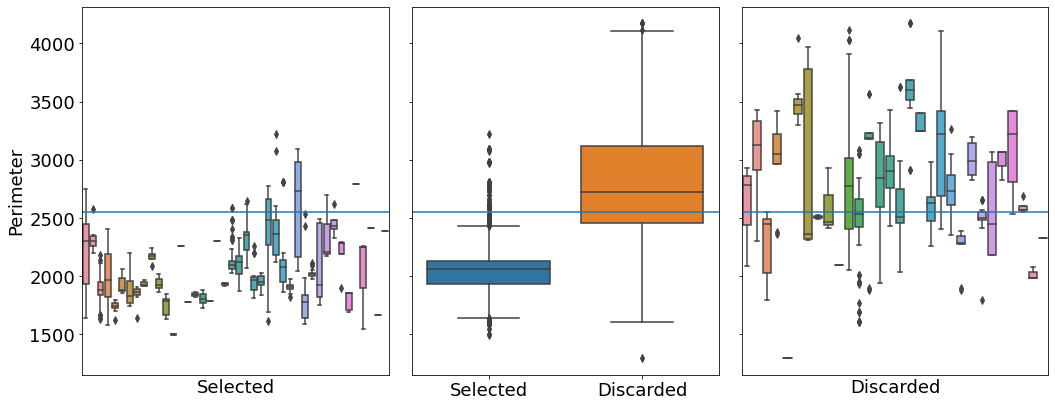

In [12]:
fig, ax = plt.subplots(1,3, figsize=(15,6), sharey='row')

good_data = filtered_data[filtered_data['good']=='Selected']
graph = sns.boxplot(x="id", y=prop, data=good_data, ax=ax[0])
graph.set_xlabel('Selected')
graph.axhline(limit)
graph.set_xticks([])
graph.set_ylabel('Perimeter')

bad_data = filtered_data[filtered_data['good']=='Discarded']
graph = sns.boxplot(x="id", y=prop, data=bad_data, ax=ax[2])
graph.set_xlabel('Discarded')
graph.axhline(limit)
graph.set_ylabel('')
graph.set_xticks([])

graph = sns.boxplot(x="good", y=prop, data=filtered_data, ax=ax[1])
graph.axhline(limit)
graph.set_xlabel('')
graph.set_ylabel('')
    
plt.tight_layout()

plt.savefig(os.path.join("..", 'data', 'img_perimter_limits.pdf'), bbox_inches='tight', dpi=300)

plt.show()

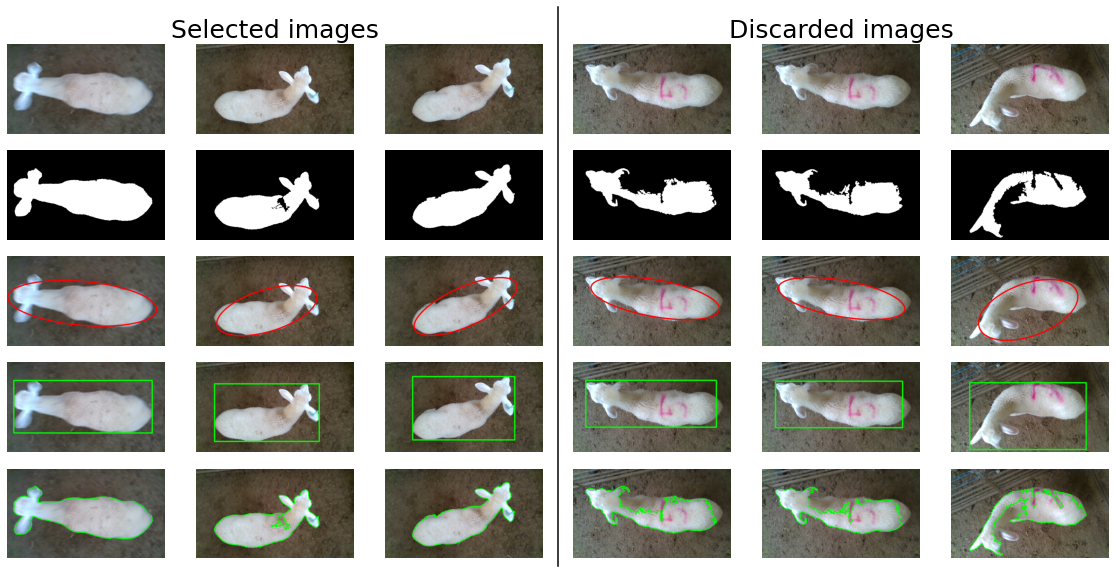

In [13]:
fig, axs = plt.subplots(5,6, figsize=(16,8))

for i in range(0,3):
    file = final_data.iloc[(i+30)]
    axs[0][i].imshow(mpimg.imread(os.path.join("..", 'data', 'results', file.filename+'_color.png')))
    axs[1][i].imshow(mpimg.imread(os.path.join("..", 'data', 'results', file.filename+'_mask.png')))
    axs[2][i].imshow(mpimg.imread(os.path.join("..", 'data', 'results', file.filename+'_ellipse.png')))
    axs[3][i].imshow(mpimg.imread(os.path.join("..", 'data', 'results', file.filename+'_bbox.png')))
    axs[4][i].imshow(mpimg.imread(os.path.join("..", 'data', 'results', file.filename+'_contour.png')))
        
    for j in range(0,5):
        axs[j][i].axis('off')
        
for i in range(3,6):
    file = discarded_data.iloc[(i+9)]
    axs[0][i].imshow(mpimg.imread(os.path.join("..", 'data', 'results', file.filename+'_color.png')))
    axs[1][i].imshow(mpimg.imread(os.path.join("..", 'data', 'results', file.filename+'_mask.png')))
    axs[2][i].imshow(mpimg.imread(os.path.join("..", 'data', 'results', file.filename+'_ellipse.png')))
    axs[3][i].imshow(mpimg.imread(os.path.join("..", 'data', 'results', file.filename+'_bbox.png')))
    axs[4][i].imshow(mpimg.imread(os.path.join("..", 'data', 'results', file.filename+'_contour.png')))
        
    for j in range(0,5):
        axs[j][i].axis('off')
        
axs[0][1].title.set_text('Selected images')
axs[0][1].title.set_size(25)
axs[0][4].title.set_text('Discarded images')
axs[0][4].title.set_size(25)

fig.add_artist(Line2D([0.50, 0.50], [0.02, 0.99], color='black'))

plt.tight_layout()

plt.savefig(os.path.join("..", 'data', 'img_filter_data.pdf'), bbox_inches='tight', dpi=300)

plt.show()

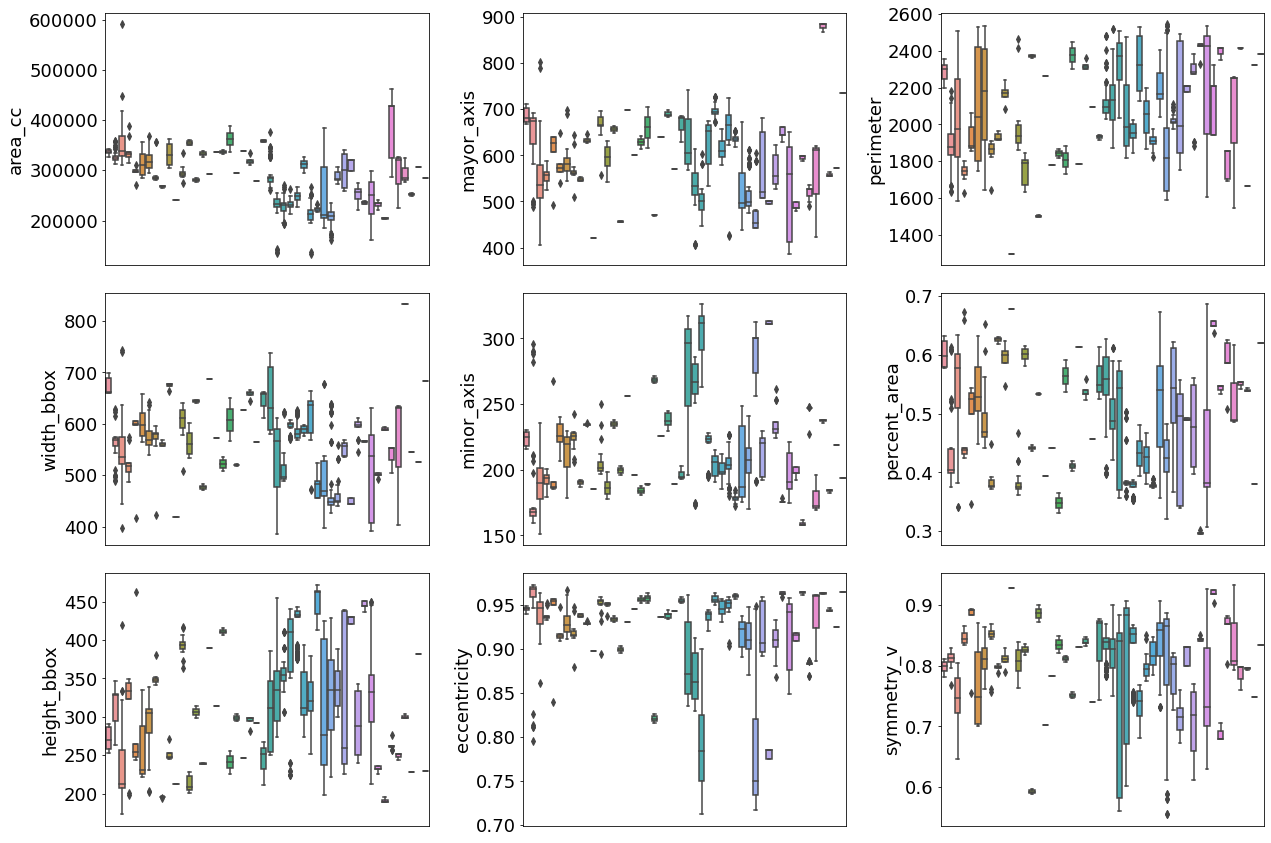

In [14]:
fig, ax = plt.subplots(3,3, figsize=(18,12))

for i in range(len(features)):
    graph = sns.boxplot(x="id", y=features[i], data=final_data, ax=ax[i%3][i//3])
    graph.set_xticks([])
    graph.set_xlabel('')
    
plt.tight_layout()

plt.savefig(os.path.join("..", 'data', 'img_similar.pdf'), bbox_inches='tight', dpi=300)
plt.show()

# Correlation matrix

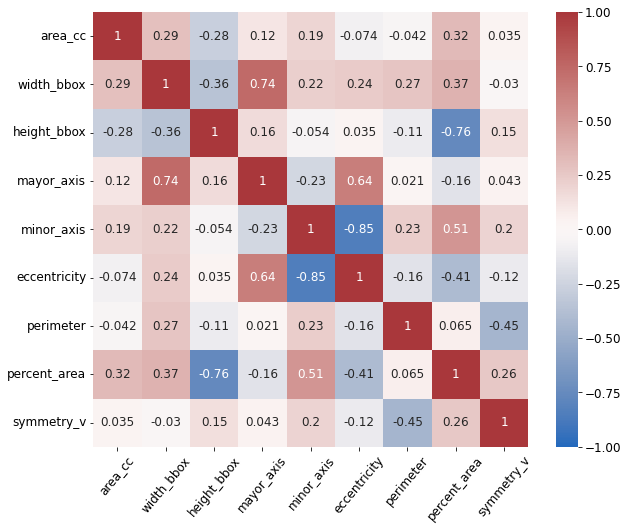

width_bbox  mayor_axis      0.740259
mayor_axis  eccentricity    0.638495
minor_axis  percent_area    0.511342
width_bbox  percent_area    0.365555
area_cc     percent_area    0.321544
dtype: float64

In [15]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10, 8))
grid = plt.GridSpec(2, 6)

corr_matrix= final_data.loc[:, features].corr()

sns.heatmap(corr_matrix, vmin=-1, vmax= 1, center = 0, annot= True, fmt='.2g', cmap="vlag", square=True)
plt.yticks(rotation=0) 
plt.xticks(rotation=50)

plt.savefig(os.path.join("..", 'data', 'img_correlation_matrix.pdf'), bbox_inches='tight', dpi=300)
plt.show()

sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool8)).stack().sort_values(ascending=False))
sol.head(5)

# Split train test

In [16]:
limit = 30
count_data = final_data.groupby(['id'])['id'].count().sort_values(ascending=False)
final_data['train_set'] = np.where(final_data['id'].isin( count_data[(count_data<limit)].index.values), True, False)
for idlamb in count_data[count_data>limit].index.values:
    filtered = final_data[final_data['id']==idlamb].sort_values(by='perimeter', ascending=False)
    filenames = filtered['filename'].values[:limit]
    final_data['train_set'] = np.where(final_data['filename'].isin(filenames), True, final_data['train_set'])
final_data = final_data[final_data['train_set']==True]

In [17]:
def train_test(all_data, train_size=0.75):
    final_ids = np.array([] )
    weights = all_data['weight'].values
    q1, q2, q3 = np.quantile(weights, 0.15), np.quantile(weights, 0.5), np.quantile(weights, 0.85)
    groups_weight = [
        all_data[(all_data['weight']>q1) & (all_data['weight']<=q2)],
        all_data[(all_data['weight']>q2) & (all_data['weight']<=q3)],
    ]
    g1 = all_data[all_data['weight']<=q1].groupby(['id'])['id'].count()
    g2 = all_data[all_data['weight']>q3].groupby(['id'])['id'].count()
    
    final_ids = np.append(final_ids, g1.index.values)
    final_ids = np.append(final_ids, g2.index.values)
    
    total = all_data.shape[0]
    training_data = g1.sum()+g2.sum()
    training_number = total*train_size
    pending_data = total-training_data
    pending_train = training_number-training_data
    train_size = pending_train/pending_data

    for g in groups_weight:
        count_data = g.groupby(['id'])['id'].count().sort_values(ascending=False)        
        train_ids = []
        train = g.shape[0]*train_size#g.sum()*0.7
        train_cont = 0            
        if count_data.shape[0]>0:
            qc1 = np.quantile(count_data.values, 0.5)
            groups = [
                count_data[count_data<=qc1],
                count_data[count_data>qc1]
            ]
            cont = 0
            while(train_cont<train):
                for gw in groups:
                    if gw.shape[0]>cont and train_cont < train:
                        train_ids.append(gw.index.values[cont])
                        train_cont += gw.values[cont]
                cont += 1
        final_ids = np.append(final_ids, train_ids)
    return [final_ids, [q1, q2, q3]]

training, quantiles = train_test(final_data)
final_data['train'] = np.where(final_data['id'].isin(training), True, False)

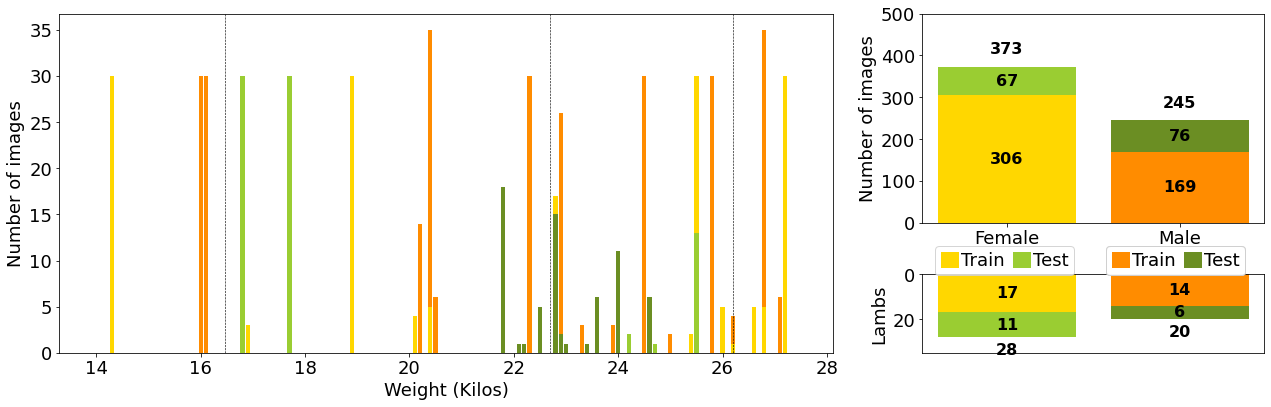

In [18]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(18, 6))
grid = plt.GridSpec(6, 6)

# HISTOGRAM
plt.subplot(grid[0:, 0:4])

plots= []
total= []
lambs = []

values = np.arange(14,27.5,0.1).astype(np.float32)
width = 0.08
bottom = np.zeros(values.shape)

color_names = [['gold', 'darkorange'],['yellowgreen', 'olivedrab']]

for data_set,colors in zip([True, False], color_names):    
    data = final_data[final_data['train']==data_set]
    
    male_data = data[data['sex']==0]
    female_data = data[data['sex']==1]

    female_info = female_data.groupby(['id', 'weight']).agg(count=('id', 'size'), mean_height=('height', 'mean')).reset_index().sort_values(by='weight')
    male_info = male_data.groupby(['id', 'weight']).agg(count=('id', 'size'), mean_height=('height', 'mean')).reset_index().sort_values(by='weight')
    
    values_female = np.zeros(values.shape)
    for _, row in female_info.iterrows():
        index = np.where(values == row.values[1])
        values_female[index] += row.values[2]
    
    values_male = np.zeros(values.shape)
    for _, row in male_info.iterrows():
        index = np.where(values == row.values[1])
        values_male[index] += row.values[2]
    
    pm = plt.bar(values,values_male, width, label='Male '+str(data_set), color = colors[0], bottom=bottom)
    pf = plt.bar(values,values_female, width,  label='Female '+str(data_set), color = colors[1], bottom=values_male)
    
    bottom=values_female    
    
    plots.append(pm)
    plots.append(pf)
    total.append([female_info['count'].sum(), male_info['count'].sum()])
    lambs.append([female_info.shape[0], male_info.shape[0]])    

plt.xlabel('Weight (Kilos)')
plt.ylabel('Number of images')
#plt.ylim([0,45]
for q in quantiles:
    plt.axvline(x = q+0.4, color = 'black', lw=0.6, ls ='--')

labels = ['Female', 'Male']


# Lambs
plt.subplot(grid[4:, 4:])

ptrain = plt.bar(labels, lambs[0],label='Train', color=color_names[0])
ptest = plt.bar(labels, lambs[1],label='Test', bottom=lambs[0], color=color_names[1])

plt.bar_label(ptrain, label_type='center', fontsize=16, color='black', fontweight='bold')
plt.bar_label(ptest, label_type='center', fontsize=16, color='black', fontweight='bold')
plt.bar_label(ptest, padding = -20, fontsize=16, fontweight='bold')

plt.ylim([0,35])

plt.gca().invert_yaxis()
plt.xticks([])
plt.ylabel('Lambs')



# Images
plt.subplot(grid[0:4, 4:])

ptrain = plt.bar(labels, total[0],label='Train', color=color_names[0])
ptest = plt.bar(labels, total[1],label='Test', bottom=total[0], color=color_names[1])

plt.bar_label(ptrain, label_type='center', fontsize=16, color='black', fontweight='bold')
plt.bar_label(ptest, label_type='center', fontsize=16, color='black', fontweight='bold')
plt.bar_label(ptest, padding = 10, fontsize=16, fontweight='bold')

plt.ylim([0,500])
plt.ylabel('Number of images')


leg1 = plt.legend([ptrain[0],ptest[0]], ['Train', 'Test'], ncol=2, numpoints=1, columnspacing = 0.5, handletextpad=0.1, bbox_to_anchor=[0.47, -0.07],handlelength=1, handleheight=1,borderpad=0.3)
plt.gca().add_artist(leg1)
leg2 = plt.legend([ptrain[1],ptest[1]], ['Train', 'Test'], ncol=2, numpoints=1, columnspacing = 0.5, handletextpad=0.1, bbox_to_anchor=[0.97, -0.07],handlelength=1, handleheight=1,borderpad=0.3)
plt.gca().add_artist(leg2)

plt.tight_layout()

plt.savefig(os.path.join("..", 'data', 'img_hist_weight.pdf'), bbox_inches='tight', dpi=300)

plt.show()

In [19]:
train_data = final_data[final_data['train']==True]
test_data = final_data[final_data['train']==False]

X_train = train_data.loc[:, features]
y_train = train_data.loc[:, ['weight']]

X_test = test_data.loc[:, features]
y_test = test_data.loc[:, ['weight']]

print('Total: ', final_data.shape[0], 'Train: ',train_data.shape[0], ' Test: ',test_data.shape[0], '%test', test_data.shape[0]/(final_data.shape[0]))

Total:  618 Train:  475  Test:  143 %test 0.2313915857605178


# Grid search training

In [20]:
if PROCESS_DATA:  
    scaler = MinMaxScaler()
    dtree = DecisionTreeClassifier()
    linearRegression = LinearRegression()   
    ridge = Ridge()
    ridgecv = RidgeCV()
    lasso = Lasso()
    lassocv = LassoCV()
    lassolars = LassoLars()
    lassolarscv = LassoLarsCV()
    decisionTree = DecisionTreeRegressor(random_state=seed)
    extraTree = ExtraTreesRegressor(random_state=seed)


    pipa = Pipeline(steps=[('scaler', scaler), ('classifier', dtree)])

    param_grid = [{'classifier':[linearRegression], 'classifier__fit_intercept': [True,False]},
                  {'classifier':[ridge], 'classifier__fit_intercept': [True,False], 'classifier__alpha': np.arange(0.5,2.5,0.1)},
                  {'classifier':[ridgecv], 'classifier__fit_intercept': [True,False], 'classifier__scoring':['r2']},
                  {'classifier':[lasso], 'classifier__fit_intercept': [True,False], 'classifier__selection':['cyclic', 'random']},
                  {'classifier':[lassocv], 'classifier__fit_intercept': [True,False], 'classifier__selection':['cyclic', 'random']},
                  {'classifier':[lassolars], 'classifier__fit_intercept': [True,False], 'classifier__alpha': np.arange(0.5,2.5,0.1)},
                  {'classifier':[lassolarscv], 'classifier__fit_intercept': [True,False]},
                  {'classifier':[decisionTree], 'classifier__criterion':['friedman_mse', 'mae'], 'classifier__max_features': ['auto', 'sqrt', 'log2']},
                  {'classifier':[extraTree], 'classifier__max_features':['sqrt', 'log2', None]}
             ]
    scoring_methods = ['r2', 'explained_variance', 'max_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 
                       'neg_root_mean_squared_error', 'neg_median_absolute_error']
    gs = GridSearchCV(estimator=pipa,
                      param_grid=param_grid,
                      cv=10,
                      refit='r2',
                      return_train_score=True,
                      n_jobs=30,
                      pre_dispatch=30,
                      scoring=scoring_methods)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        gs.fit(X_train, y_train.values.ravel())
    
    joblib.dump({'gs': gs,
                 'scaler': scaler,
                 'linearRegression': linearRegression,
                 'ridge': ridge,
                 'ridgecv': ridgecv,
                 'lasso': lasso,
                 'lassocv': lassocv,
                 'lassolars': lassolars,
                 'lassolarscv': lassolarscv,
                 'decisionTree': decisionTree,
                 'extraTree': extraTree
                }, 
                os.path.join("..", 'data', datetime.datetime.now().strftime("%Y%m%d%H%M")+'_model.joblib_dump')) 

else:
    #Load last models
    os.chdir(os.path.join("..", 'data'))
    files = glob.glob("*_model.joblib_dump")
    files.sort(reverse=True)
    models = joblib.load(files[0])
    gs = models['gs']
    scaler = models['scaler']
    linearRegression = models['linearRegression']
    ridge = models['ridge']
    ridgecv = models['ridgecv']
    lasso= models['lasso']
    lassocv = models['lassocv']
    lassolars = models['lassolars']
    lassolarscv = models['lassolarscv']
    decisionTree = models['decisionTree']
    extraTree = models['extraTree']

# Evaluate best model

In [21]:
best_estimator = gs.best_estimator_
print('Best model:', best_estimator.named_steps.classifier)
print(gs.best_params_)

results = pd.DataFrame(gs.cv_results_)
results['param_classifier'] = results.param_classifier.astype(str).str.split('(', expand=True)[0]
best_results_by_model = pd.pivot_table(data=results,
               index='param_classifier',
               values = ['mean_test_r2', 'mean_test_explained_variance', 'mean_test_max_error', 
                         'std_test_r2', 'std_test_explained_variance', 'std_test_max_error'
                        ],
               aggfunc='max'
              ).reindex(['mean_test_r2', 'mean_test_explained_variance', 'mean_test_max_error', 
                         'std_test_r2', 'std_test_explained_variance', 'std_test_max_error'], axis=1)
print('Mean scores during Cross Validation')
best_results_by_model.sort_values(by='mean_test_r2', ascending=False, inplace=True)
best_results_by_model['mean_test_r2'] = best_results_by_model['mean_test_r2']*100
best_results_by_model['mean_test_explained_variance'] = best_results_by_model['mean_test_explained_variance']*100
best_results_by_model['std_test_r2'] = best_results_by_model['std_test_r2']*100
best_results_by_model['std_test_explained_variance'] = best_results_by_model['std_test_explained_variance']*100
display((best_results_by_model).round(2))

#Save results in latex file
with open(os.path.join("..", 'data', 'results_by_model.tex'), 'w') as tf:
     tf.write(best_results_by_model.to_latex(float_format="%.2f"))

Best model: ExtraTreesRegressor(max_features=None, random_state=2)
{'classifier': ExtraTreesRegressor(max_features=None, random_state=2), 'classifier__max_features': None}
Mean scores during Cross Validation


,mean_test_r2,mean_test_explained_variance,mean_test_max_error,std_test_r2,std_test_explained_variance,std_test_max_error
param_classifier,,,,,,
ExtraTreesRegressor,91.94,92.19,-3.24,14.37,12.97,2.15
DecisionTreeRegressor,88.47,88.85,-4.82,37.22,36.91,3.50
Ridge,9.43,12.31,-7.05,131.13,128.83,2.74
LassoCV,7.79,10.14,-7.38,136.09,133.67,2.78
LassoLarsCV,7.37,9.86,-7.37,132.40,127.24,2.93
RidgeCV,4.89,8.09,-7.35,132.77,128.32,2.90
LinearRegression,4.66,8.40,-7.37,131.68,126.18,2.94
LassoLars,-50.82,-0.00,-7.45,751.50,102.84,1.82
Lasso,-122.31,-0.00,-7.45,233.03,77.59,1.74


In [22]:
print('TEST DATA')
best_estimator_predictions = best_estimator.predict(X_test)
print('R2 score:', r2_score(y_test, best_estimator_predictions))
print('Mean Square Error:', mean_squared_error(y_test, best_estimator_predictions))
print('Explained variance score:', explained_variance_score(y_test, best_estimator_predictions))
print('Max error:', max_error(y_test, best_estimator_predictions))
print('Mean absolute error:', mean_absolute_error(y_test, best_estimator_predictions))
print('Mean relative error:', mean_relative_error(y_test, best_estimator_predictions))

TEST DATA
R2 score: 0.9040603157003083
Mean Square Error: 0.9772546013986108
Explained variance score: 0.9191997907595848
Max error: 4.076000000000018
Mean absolute error: 0.7513566433566464
Mean relative error: 0.037325336232517145


In [23]:
f_v= ['area_cc', 'width_bbox', 'height_bbox', 'mayor_axis', 'minor_axis', 'eccentricity', 'perimeter', 'percent_area', 'symmetry_v']
f_h= ['area_cc', 'width_bbox', 'height_bbox', 'mayor_axis', 'minor_axis', 'eccentricity', 'perimeter', 'percent_area', 'symmetry']
f_hv= ['area_cc', 'width_bbox', 'height_bbox', 'mayor_axis', 'minor_axis', 'eccentricity', 'perimeter', 'percent_area', 'symmetry', 'symmetry_v']


column_names = ['Features', 'R2', 'MAE', 'Max. Error','MRAE']
features_train = pd.DataFrame(columns=column_names)

for fea, name in zip([f_v, f_h, f_hv], ['8F + Symmetry vertical', '8F + Symmetry horizontal', '8F + S. vertical + S. horizontal']):
    X_train = train_data.loc[:, fea]
    y_train = train_data.loc[:, ['weight']]

    X_test = test_data.loc[:, fea]
    y_test = test_data.loc[:, ['weight']]
    reg = ExtraTreesRegressor(max_features=None, random_state=seed).fit(X_train, y_train)
    best_estimator_predictions = reg.predict(X_test)
    df = pd.DataFrame([{
        'Features': name,
        'R2':  r2_score(y_test, best_estimator_predictions),
        'MAE': mean_absolute_error(y_test, best_estimator_predictions),
        'Max. Error': max_error(y_test, best_estimator_predictions),
        'MRAE' :mean_relative_error(y_test, best_estimator_predictions)
    }])
    features_train = pd.concat([features_train, df])

features_train['R2'] = features_train['R2'].astype('float32') 
features_train['MAE'] = features_train['MAE'].astype('float32') 
features_train['Max. Error'] = features_train['Max. Error'].astype('float32')  
features_train['MRAE'] = features_train['MRAE'].astype('float32')   

display((features_train).round(4))

#Save results in latex file
with open(os.path.join("..", 'data', 'results_symmetry.tex'), 'w') as tf:
     tf.write(features_train.to_latex(float_format="%.4f"))

,Features,R2,MAE,Max. Error,MRAE
0,8F + Symmetry vertical,0.9041,0.7514,4.076,0.0373
0,8F + Symmetry horizontal,0.8765,0.8886,3.651,0.0451
0,8F + S. vertical + S. horizontal,0.8682,0.9239,4.429,0.0466


In [24]:
predicted_data = final_data.loc[X_test.index]
predicted_data.insert(13, "predicted_weight", best_estimator_predictions, True)
predicted_data.insert(14, "difference", abs(predicted_data['weight']-predicted_data['predicted_weight']), True) 
#predicted_data = predicted_data.reindex(columns=['filename', 'id', 'sex', 'weight', "predicted_weight", "difference", 'area', 'width', 'height', 'MA', 'ma', 'eccentricity', 'perimeter', 'per_area', 'symmetry', 'mask_method'])
predicted_data.to_csv(os.path.join("..", 'data', 'id_weight_sex_uuid_data_predicted.csv'), sep=';', decimal=',')
predicted_data = predicted_data.sort_values(by='difference')

In [25]:
def quantiles(data):
    data_sort = data.sort_values(by=['difference'],ignore_index=True)
    df = pd.DataFrame()
    differences = data_sort
    for q in np.arange(0.00,1,0.01):
        quantile = data_sort.difference.quantile(q)
        df = df.append(
            {'q':q*100, 'diff':quantile}, 
            ignore_index = True)
    quantile = data_sort.difference.quantile(1)
    df = df.append(
            {'q':100, 'diff':quantile}, 
            ignore_index = True)
    return df
q_predictions = quantiles(predicted_data)

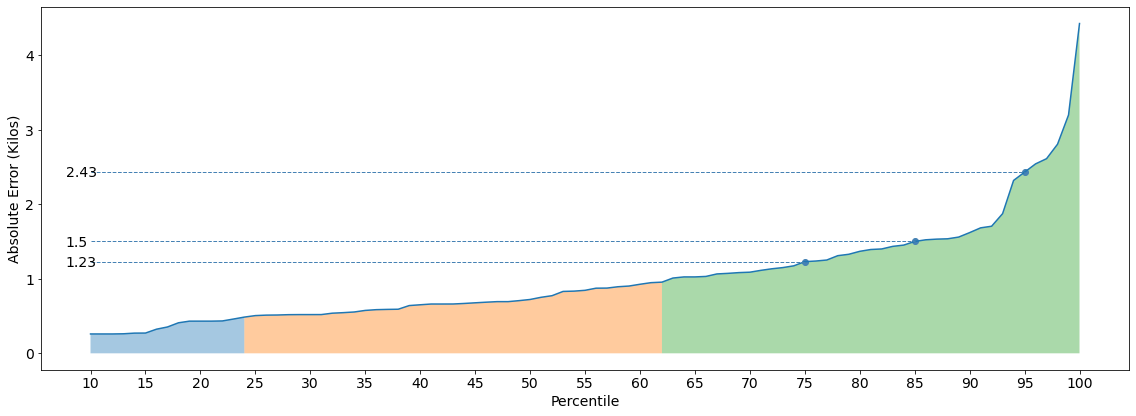

In [26]:
plt.rcParams.update({'font.size': 14})
plt.rcParams["figure.figsize"] = (16,6)

plt.plot(q_predictions['q'][10:], q_predictions['diff'][10:])
limit1 = q_predictions[q_predictions['diff']<0.5].max()['q'].astype(np.int8)
limit2 = q_predictions[q_predictions['diff']<1].max()['q'].astype(np.int8)
plt.fill_between(q_predictions['q'][10:limit1+1], q_predictions['diff'][10:limit1+1], alpha=0.4)
plt.fill_between(q_predictions['q'][limit1:limit2+1], q_predictions['diff'][limit1:limit2+1], alpha=0.4)
plt.fill_between(q_predictions['q'][limit2:], q_predictions['diff'][limit2:], alpha=0.4)

    
for q in range(75,101,10):
    x = q_predictions.loc[q]['q']
    y = q_predictions.loc[q]['diff']    
    label = format(y,".3g")
    info = plt.scatter(x,y, color='steelblue') 
    plt.annotate(label,(10,y),textcoords="offset points", xytext=(-25,-5))    
    
    plt.hlines(y = y, color = 'steelblue', linestyle = '--',  linewidth=1, xmin=10,xmax=x)
    
plt.xticks(range(10,101,5))
plt.xlabel('Percentile')
plt.ylabel('Absolute Error (Kilos)')

plt.tight_layout()

plt.savefig(os.path.join("..", 'data', 'img_quantiles.pdf'), bbox_inches='tight', dpi=300)

plt.show()

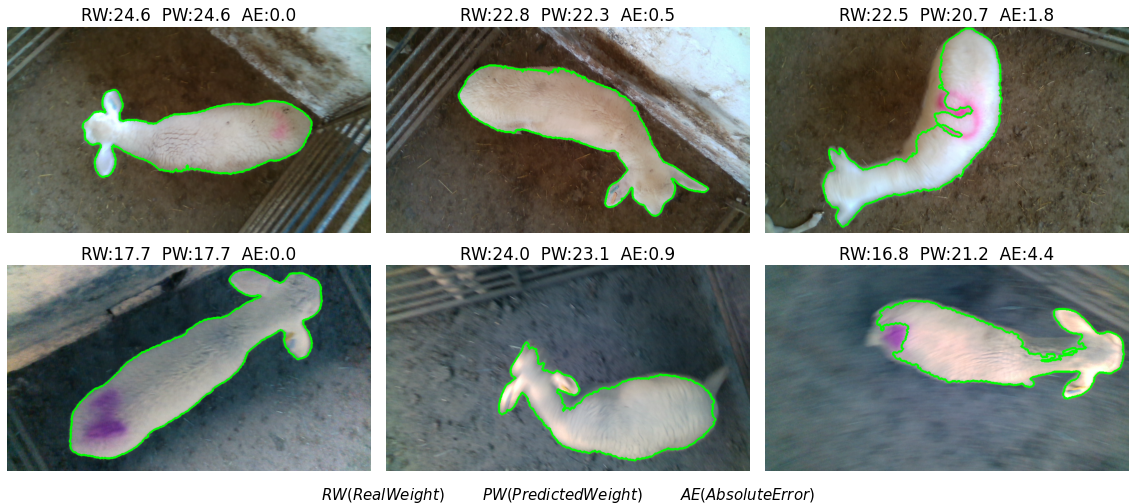

In [27]:
import matplotlib.transforms as mtrans
groups = [
    predicted_data[predicted_data['difference']<0.5].sort_values(by=['difference'],ascending=True,ignore_index=True),
    predicted_data[(predicted_data['difference']>0.5)&(predicted_data['difference']<1)].sort_values(by=['difference'],ascending=True,ignore_index=True),
    predicted_data[predicted_data['difference']>1].sort_values(by=['difference'],ascending=False,ignore_index=True)
]

max_images = 6
fig, axs = plt.subplots(2,3, figsize=(16,7))

trans = mtrans.blended_transform_factory(fig.transFigure,mtrans.IdentityTransform())
txt = fig.text(0.5, 0, "$\it{RW (Real Weight)}$        $\it{PW (Predicted Weight)}$        $\it{AE (Absolute Error)}$", ha='center', va='bottom', fontsize=15)
txt.set_transform(trans)

ids = [[0, 4],[10, 50],[10, 0]]
for i in range(0,max_images):
    file = groups[i%3].loc[ids[i%3][int(i/3)]]
    img=mpimg.imread(os.path.join("..", 'data', 'results', file.filename+'_contour.png'))
    axs[int(i/3)][i%3].imshow(img)
    axs[int(i/3)][i%3].axis('off')
    axs[int(i/3)][i%3].title.set_text('RW:{:.1f}  PW:{:.1f}  AE:{:.1f}'.format(file.weight, file.predicted_weight, abs(file.weight-file.predicted_weight)))

plt.tight_layout()
plt.savefig(os.path.join("..", 'data', 'img_big_diff.pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [28]:
predicted_lamb = predicted_data.groupby(by='id').agg(count=('id', 'size'), mean_height=('height', 'mean'), weight=('weight', 'mean'), mae=('difference', 'mean'), max_error=('difference', 'max')).reset_index().sort_values(by='weight', ignore_index=True)

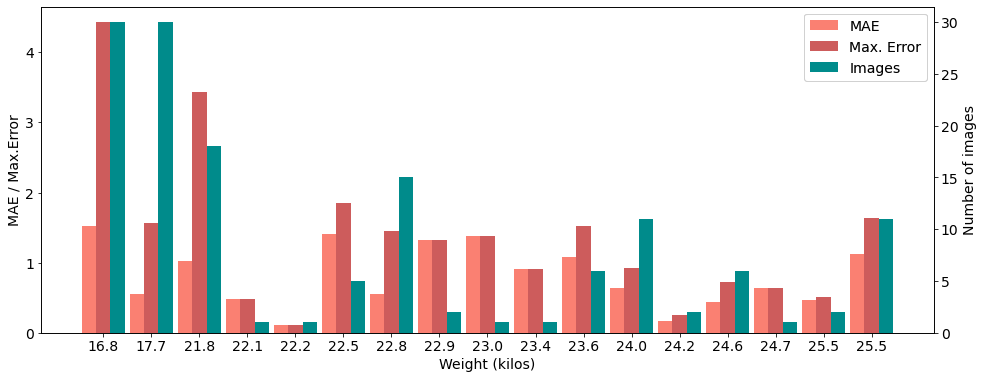

In [29]:
fig, ax = plt.subplots(figsize=(16, 6))

x = np.arange(predicted_lamb.shape[0])

p_mae = ax.bar(x-0.3, predicted_lamb['mae'], 0.3,label='MAE', color='salmon')
p_max = ax.bar(x, predicted_lamb['max_error'], 0.3,label='Max Error', color='indianred')

ax2 = ax.twinx()
p_count = ax2.bar(x+0.3, predicted_lamb['count'], 0.3,label='Images', color='darkcyan')

ax.set_xticks(x, [ "{:0.1f}".format(x) for x in predicted_lamb['weight'].values ])

ax.set_xlabel('Weight (kilos)')
ax.set_ylabel('MAE / Max.Error')
ax2.set_ylabel('Number of images')
leg1 = plt.legend([p_mae[0],p_max[0], p_count[0]], ['MAE', 'Max. Error', 'Images'])
plt.gca().add_artist(leg1)

plt.savefig(os.path.join("..", 'data', 'img_error_lamb.pdf'), bbox_inches='tight', dpi=300)

plt.show()